In [1]:
%matplotlib inline
from Stupid_digits import *
from sklearn.metrics import accuracy_score
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from matplotlib import animation
from copy import copy

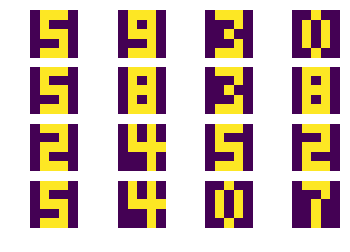

In [4]:
X,y = stupid_digits_dataset(1000)
plt.figure('data')
for _ in np.arange(16):
    plt.subplot(4,4,_+1)
    plt.imshow(X[_].reshape((5,5)), interpolation=None)
    plt.axis('off')
plt.show()

In [8]:
from brian2 import *
import numpy as np
from time import clock

import json
import codecs

def sv_json(obj, path, encoding="cp1251"):
    with codecs.open(path, "w", encoding=encoding) as f:
        json.dump(obj, f, indent=1, ensure_ascii=0)
        
def ld_json(path, encoding="cp1251"):
    with codecs.open(path, "r", encoding=encoding) as f:
        return json.load(f)

start_scope()

time_per_image = 100*ms
time_step = 0.1*ms
#alpha = 30*ms
#beta = 500*ms
tau = 20*ms # tau for neuron's voltage 'v'
tau_I = 15*ms # tau for neuron's current 'I'
tau_h = 50*ms # tau for neuron's treshold

lr = 1.
lr_intr = 1.
lr_rec = 1.
wmax = 1.
decay = 0.00

c_inp = 1.
c_intr = 1.
c_out = 1.
c_intr_out = 1.
c_rec = 1.

c_diff = 1.0

eqs_input_neuron = '''
rates : Hz
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
train :1
x :1
y :1
z :1
'''

eqs_hidden_neuron_pos = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_intr/dt = -I_intr/tau_I :1
I = I_inp + I_intr: 1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
dhold_hidden/dt = -hold_hidden/tau_h : 1
hold = clip(hold_hidden, 1, 100) : 1
train :1
x :1
y :1
z :1
'''

eqs_hidden_neuron_neg = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
I = I_inp: 1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
dhold_hidden/dt = -hold_hidden/tau_h : 1
hold = clip(hold_hidden, 0, 100) : 1
train :1
x :1
y :1
z :1
'''

eqs_output_neuron_pos = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
dI_intr/dt = -I_intr/tau_I :1
I_teacher :1
I = I_inp + I_intr + I_teacher : 1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
dhold_output/dt = -hold_output/tau_h  : 1
hold = clip(hold_output, 1, 100) : 1
train :1
x :1
y :1
z :1
'''

eqs_output_neuron_neg = '''
dv/dt = (-v+I)/tau : 1 (unless refractory)
dI_inp/dt = -I_inp/tau_I :1
I = I_inp : 1
da/dt = -a/alpha : 1
dtheta/dt = -theta/beta : 1
diff = a - c_diff * theta : 1
dhold_output/dt = -hold_output/tau_h  : 1
hold = clip(hold_output, 0, 100) : 1
train :1
x :1
y :1
z :1
'''


eqs_syn = '''
distance = sqrt((x_post - x_pre)**2 + (y_post - y_pre)**2 + (z_post - z_pre)**2) :1
dw/dt = -w/(decay_time)*distance: 1
'''

eqs_output_syn = '''
dw/dt = -w/(decay_time):1
'''

# equations that describe changes if presynaptic spike of the forward-riented synapse of input layer occures
eqs_input_pre = '''
I_inp_post += w * c_inp
a_pre += 1./n_hidden *1*ms/(alpha)
theta_pre += 1./n_hidden *1*ms/(beta)
w = clip(w + train_pre*(-decay + lr*diff_post/distance), 0, wmax)
'''

# equations that describe changes if postsynaptic spike of the forward synapse occures
eqs_input_post = '''
'''

# equations that describe changes if spike of the intr synapse occures
eqs_intrinsic_pos_pre = '''
I_inp_post += w * c_intr
a_pre += 1.*ms/(alpha)
theta_pre += 1.*ms/(beta)
'''

eqs_intrinsic_pos_post = '''
a_post += 1*ms/(alpha)
theta_post += 1*ms/(beta)
'''

eqs_intrinsic_neg_pre = '''
I_intr_post += w * c_intr
w = clip(w + train_pre*(lr_intr*diff_post/distance), -wmax, 0)
'''

eqs_intrinsic_neg_post = '''
'''

# equations that describe changes if presynaptic spike of the forward synapse of hidden layer occures
eqs_output_pre = '''
I_inp_post += w * c_inp
w = clip(w + train_pre*(-decay + lr*diff_post), 0, wmax)
'''

#a_post += 1./classes *1*ms/(alpha)
#theta_post += 1./classes *1*ms/(beta)
# equations that describe changes if postsynaptic spike of the forward synapse of hidden layer occures
eqs_output_post = '''
'''

reset_hidden = '''
v = 0
hold_hidden = 1.2*hold_hidden
'''

reset_output = '''
v = 0
hold_output += 1.2*hold_output
'''

class DeepSpatialPerceptron(object):
    def __init__(self, X, y, params_to_optimize, time_step = 0.1*ms, time_per_image = 100*ms, inits = None, monitor = None, cheat = False, mod = True, 
                high_verbosity=True, web=False):   
        '''
        X - np.array with shape (N samples, N features)
        y - np.array with shape (N samples)
        n_hiiden - number of hidden neurons
        inits  - list of 4 lists that contain 'distribution' and 'condition' parameters 
        for input, intrinsic, output and intrinsic_output connections
            Example: inits = [['equal_[0,1]', None], ['equal_[-1,0]', 'i!=j'], 
                     ['equal_[0,1]', 'reciprocal'], ['equal_[-1,0]', 'i!=j']]
        monitor - dictionary with keys 'P', 'G', 'H' or connection names. Each key argument value is 2-d list.
        First one is a list of what parameters to record for the object in the key name and second one is dt.
            Example: monitor = {'H':[['a','I'], 25*ms]}
        cheat - True if you wanna use pretrained model with first layer initialized from some objects of training data
        '''
        self.high_verbosity = high_verbosity
        self.web = web
        global alpha, beta, lr, lr_intr, c_inp, c_intr, c_diff, Teacher_amplitude, decay_time
        self.time_step = time_step
        self.time_per_image = time_per_image

        alpha = params_to_optimize['alpha']
        beta = params_to_optimize['beta']
        lr = params_to_optimize['lr']
        lr_intr = params_to_optimize['lr_intr']
        c_inp = params_to_optimize['c_inp']
        c_intr = params_to_optimize['c_intr']
        c_diff = params_to_optimize['c_diff']
        Teacher_amplitude = params_to_optimize['Teacher_amplitude']
        decay_time = params_to_optimize['decay_time']
        
        self.X = X
        if self.X is not None:
            global n_input
            n_input = int(X.shape[1])
        else:
            raise ValueError('No data provided to the simulation')
        
        self.y = y
        global classes
        classes = int(len(set(y)))
        #classes = 10
        
        # list to store initial values for synapses in order [input, intrinsic, output, intrinsic_output]
        if inits:
            pass
        else:
            inits = [['spatial', None], ['equal_[0,1]', None], ['ones', 'i==j'], 
                     ['equal_[-1,0]', 'i!=j']]
         
        #creatitng the network: groups and synapses
        
        self.P = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear', 
                             refractory=2*ms, dt = time_step, name='P')
        self.M = NeuronGroup(n_input, eqs_input_neuron, threshold='rand()<rates*dt', method='linear', 
                             refractory=2*ms, dt = time_step, name='M')
        
        self.G_pos = NeuronGroup(n_hidden, eqs_hidden_neuron_pos, method='linear', threshold='v > hold', 
                        reset=reset_hidden, refractory=2*ms, dt=time_step, name = 'G_pos')
        self.G_neg = NeuronGroup(n_hidden, eqs_hidden_neuron_neg, method='linear', threshold='v > hold', 
                        reset=reset_hidden, refractory=2*ms, dt=time_step, name = 'G_neg')
        
        self.create_synapse('input_syn', self.P, self.G_pos, eqs_syn, eqs_input_pre, eqs_input_post,
                           distribution=inits[0][0], condition=inits[0][1])
        self.create_synapse('input_inverse_syn', self.M, self.G_pos, eqs_syn, eqs_input_pre, eqs_input_post,
                           distribution=inits[0][0], condition=inits[0][1])
        
        self.create_synapse('intrinsic_syn_pos', self.G_pos, self.G_neg, eqs_syn, 
                            eqs_intrinsic_pos_pre, eqs_intrinsic_pos_post, 
                            distribution=inits[2][0], condition=inits[2][1])#, method='linear')
        self.create_synapse('intrinsic_syn_neg', self.G_neg, self.G_pos, eqs_syn, 
                            eqs_intrinsic_neg_pre, eqs_intrinsic_neg_post, 
                            distribution=inits[3][0], condition=inits[3][1])#, method='linear')
        
        self.H_pos = NeuronGroup(classes, eqs_output_neuron_pos, method='linear', threshold='v > hold', 
                        reset=reset_output, refractory=2*ms, dt=time_step, name = 'H_pos')
        self.H_neg = NeuronGroup(classes, eqs_output_neuron_neg, method='linear', threshold='v > hold', 
                        reset=reset_output, refractory=2*ms, dt=time_step, name = 'H_neg')
        
        self.create_synapse('output_syn', self.G_pos, self.H_pos, eqs_output_syn, eqs_output_pre, eqs_output_post,
                           distribution=inits[1][0], condition=inits[1][1])#, method='linear')
        self.create_synapse('intrinsic_output_syn_pos', self.H_pos, self.H_neg, eqs_syn, 
                            eqs_intrinsic_pos_pre, eqs_intrinsic_pos_post, 
                            distribution=inits[2][0], condition=inits[2][1])#, method='linear')
        self.create_synapse('intrinsic_output_syn_neg', self.H_neg, self.H_pos, eqs_syn, 
                            eqs_intrinsic_neg_pre, eqs_intrinsic_neg_post, 
                            distribution=inits[3][0], condition=inits[3][1])#, method='linear')
        
        # set random values to a and theta for all groups, set train parameter of the group to 1.
        self.random_init_groups([self.P, self.M, self.G_pos, self.G_neg, self.H_pos, self.H_neg], [1, 1, 1, 1, 1, 1])
        self.P.z = np.zeros_like(self.P.z)
        self.M.z = np.ones_like(self.M.z)*(-0.2)
        self.G_pos.z = np.ones_like(self.G_pos.z)*2
        self.G_neg.z = np.ones_like(self.G_neg.z)*2.5
        self.H_pos.z = np.ones_like(self.H_pos.z)*4
        self.H_neg.z = np.ones_like(self.H_neg.z)*4.5
        if self.high_verbosity:
            self.plot_3D_network([[self.P, self.G_pos, self.input_syn], 
                                 [self.M, self.G_pos, self.input_inverse_syn], 
                                 #[self.G_neg, self.G_pos, self.intrinsic_syn_neg],
                                 [self.G_pos, self.H_pos, self.output_syn]])
        # operation to do during simulation every dt 
        self.network_op = NetworkOperation(self.update_func, dt=time_per_image)
        
        # params to give for constructing the simulation
        params = [self.P, self.M, self.G_pos, self.G_neg, self.H_pos,  self.H_neg, 
                  self.input_syn, self.input_inverse_syn, 
                  self.intrinsic_syn_pos, self.intrinsic_syn_neg, 
                  self.output_syn, 
                  self.intrinsic_output_syn_pos, self.intrinsic_output_syn_neg,
                  self.network_op]
        
        self.monitor = monitor
        # adding monitors to the simulation params
        # TO DO: OPTIMIZE!!!!!
        if self.monitor:
            if 'P' in self.monitor.keys():
                self.StateMonitorP = StateMonitor(self.P, self.monitor['P'][0], record=self.monitor['P'][2],
                                                  dt=monitor['P'][1],
                                                  name = 'StateMonitorP')
                params.append(self.StateMonitorP)
            else:
                self.StateMonitorP = None
            
            if 'M' in self.monitor.keys():
                self.StateMonitorM = StateMonitor(self.M, self.monitor['M'][0], record=self.monitor['M'][2],
                                                  dt=monitor['M'][1],
                                                  name = 'StateMonitorM')
                params.append(self.StateMonitorM)
            else:
                self.StateMonitorM = None
                
            if 'G_pos' in monitor.keys():
                self.StateMonitorG_pos = StateMonitor(self.G_pos, self.monitor['G_pos'][0], record=self.monitor['G_pos'][2],
                                                  dt=monitor['G_pos'][1],
                                                  name = 'StateMonitorG_pos')
                params.append(self.StateMonitorG_pos)
            else:
                self.StateMonitorG_pos = None
            
            if 'G_neg' in monitor.keys():
                self.StateMonitorG_neg = StateMonitor(self.G_pos, self.monitor['G_neg'][0], record=self.monitor['G_neg'][2],
                                                  dt=monitor['G_neg'][1],
                                                  name = 'StateMonitorG_neg')
                params.append(self.StateMonitorG_neg)
            else:
                self.StateMonitorG_neg = None
                
                
            if 'H_pos' in monitor.keys():
                self.StateMonitorH_pos = StateMonitor(self.H_pos, self.monitor['H_pos'][0], record=self.monitor['H_pos'][2], 
                                                  dt=monitor['H_pos'][1],
                                                  name = 'StateMonitorH_pos')
                params.append(self.StateMonitorH_pos)
            else:
                self.StateMonitorH_pos = None
            
            if 'H_neg' in monitor.keys():
                self.StateMonitorH_neg = StateMonitor(self.H_neg, self.monitor['H_neg'][0], record=self.monitor['H_neg'][2], 
                                                  dt=monitor['H_neg'][1],
                                                  name = 'StateMonitorH_neg')
                params.append(self.StateMonitorH_neg)
            else:
                self.StateMonitorH_neg = None
                
                
            if 'Input_weights' in monitor.keys():
                self.SynapseMonitorInput = StateMonitor(self.input_syn, self.monitor['Input_weights'][0], 
                                                        record=self.monitor['Input_weights'][2],
                                                        dt = monitor['Input_weights'][1],
                                                        name = 'SynapseMonitorInput')
                params.append(self.SynapseMonitorInput)
            else:
                self.SynapseMonitorInput = None
                
            if 'Input_inverse_weights' in monitor.keys():
                self.SynapseMonitorInput_inverse = StateMonitor(self.input_inverse_syn, self.monitor['Input_inverse_weights'][0], 
                                                        record=self.monitor['Input_inverse_weights'][2],
                                                        dt = monitor['Input_inverse_weights'][1],
                                                        name = 'SynapseMonitorInput_inverse')
                params.append(self.SynapseMonitorInput_inverse)
            else:
                self.SynapseMonitorInput_inverse = None
                
            if 'Intrinsic_weights_neg' in monitor.keys():
                self.SynapseMonitorIntrinsi_negc = StateMonitor(self.intrinsic_syn_neg, self.monitor['Intrinsic_weights_neg'][0],
                                                        record=self.monitor['Intrinsic_weights_neg'][2],
                                                        dt = monitor['Intrinsic_weights_neg'][1],
                                                        name = 'SynapseMonitorIntrinsic_neg')
                params.append(self.SynapseMonitorIntrinsic_neg)
            else:
                self.SynapseMonitorIntrinsic_neg = None
                
            if 'Output_weights' in monitor.keys():
                self.SynapseMonitorOutput = StateMonitor(self.output_syn, self.monitor['Output_weights'][0],
                                                        record=self.monitor['Output_weights'][2],
                                                        dt = monitor['Output_weights'][1],
                                                        name = 'SynapseMonitorOutput')
                params.append(self.SynapseMonitorOutput)
            else:
                self.SynapseMonitorOutput = None
                
            if 'Intrinsic_output_weights_neg' in monitor.keys():
                self.SynapseMonitorIntrinsicOutput_neg = StateMonitor(self.intrinsic_output_syn_neg, self.monitor['Intrinsic_output_weights_neg'][0],
                                                        record=self.monitor['Intrinsic_output_weights_neg'][2], 
                                                        dt = monitor['Intrinsic_output_weights_neg'][1],
                                                        name = 'SynapseMonitorIntrinsicOutput_neg')
                params.append(self.SynapseMonitorIntrinsicOutput_neg)
            else:
                self.SynapseMonitorIntrinsicOutput_neg = None
        
        # setting params to the simulation
        self.network = Network(params)
        if self.high_verbosity:
            print ('Network created using:')
            for param in params:
                print ('\t'+param.name + '   dt = '+str(param.clock.dt))
            
        self.shown_labels = [] #list to store shown labels during lifetime of the simulation
        self.predictions = [] #list to store preds during lifetime of the simulation
        self.counter = 0 # counter for shown images during lifetime of the simulation
        self.mod = mod # binary, True if train mod, False for test mod
        self.clocks = [] # clocks list per image to monitor if there are to many params to record and RAM is dying 
        self.clocks.append(0)
        
        # never use this
        if cheat:
            dig_y = y[:int(n_hidden)]
            dig_X = X[:int(n_hidden)]
            for s in np.arange(int(n_hidden)):
                for j in np.arange(int(n_input)):
                    # shape dig_X = (n_hidden, n_input)
                    # shape inp_syn is a vectorizes matrix
                    # W_11 ..... W_n1
                    # ..
                    # W_1m ..... W_nm
                    # n = post length, m = pre length
                    self.input_syn.w[s+j*int(n_hidden)] = dig_X[s][j]
            print ('I used cheat initialisation')
    
    def random_init_groups(self, groups, trains):
        '''
        random inits for a and theta of neuron groups + setting trains for neuron groups
        groups - list of NeuronGroup objects, trains - list of train values (Ex. [1, 1, 1] if all are trainable)'''
        if self.high_verbosity:
            print ()
        for group,tr in zip(groups, trains):
            if tr:
                group.train = np.ones_like(group.train)
                if self.high_verbosity:
                    print (group.name + ' ' + str(group.N) + ' trainable')
            else:
                group.train = np.zeros_like(group.train)
                if self.high_verbosity:
                    print (group.name + ' non-trainable')
            group.a = np.random.rand(len(group))*0.5
            group.theta = np.random.rand(len(group))*0.5
            
            if group == self.P or group == self.M or group == self.G_pos or group == self.G_neg:
                Grid_rad = sqrt(group.N)
                right = sqrt(group.N)/2-0.5
                left = - right
                q=0
                for m in np.arange(left, right+1, 1.):
                    for k in np.arange(left, right+1, 1.):
                        group.x[q]=k
                        group.y[q]=m
                        q += 1
        if self.high_verbosity:
            print ()
    
    def create_synapse(self, name, pre, post, eqs, on_pre, on_post, distribution = 'equal_[0,1]', condition = None):
        
        '''
        AUTO-creating synapses between pre and post NeuronGroup with name='name'
        eqs, on_pre, on_post -  standart paramtres for Synapses
        distribution - string, initial values for weights
        condition - string, some cpecific conditions for connecting, same as in connect() method for Synapses
        extra value for conditions is 'reciprocal'. Should be used if Synapse object has w_rec reciprocal weights'''
        
        exec('self.'+ name + '= Synapses(pre, post, eqs, on_pre = on_pre, on_post = on_post, dt = time_step)')
        if self.high_verbosity:
            print ('{} -> {}, initial distribution = {}'.format(pre.name, post.name, distribution))
        if condition:
            if condition == 'reciprocal':
                exec('self.'+ name + '.connect()')
            else:
                exec('self.'+ name + ".connect(condition = '" + condition +"')")
        else: 
            exec('self.'+ name + '.connect()')

        if distribution == 'equal_[0,1]':    
            exec('self.' + name +'.w = np.random.random(len(pre)*len(post))')
        if distribution == 'equal_[-1,1]'and condition == 'i!=j':
            exec('self.' + name +'.w = (np.random.random(len(pre)*(len(post)-1)) - 0.5) * 2.')
        if distribution == 'equal_[-1,0]'and condition == 'i!=j':
            exec('self.' + name +'.w = (np.random.random(len(pre)*(len(post)-1)) - 1.)')  
        if distribution == 'norm':
            exec('self.' + name +'.w = np.random.randn(len(pre)*len(post))')
        if distribution == 'zeros':
            exec('self.' + name +'.w = np.zeros_like(self.' + name +'.w)')     
        if distribution == 'ones':
            exec('self.' + name +'.w = np.ones_like(self.' + name +'.w)')
        if distribution == 'spatial':
            matrix_weights = []
            if name == 'input_syn':
                matrix_weights = np.array([[self.input_syn.w[int(r + j * int(self.input_syn.target.N))]
                        for j in np.arange(int(self.input_syn.source.N))] 
                        for r in np.arange(int(self.input_syn.target.N))]).reshape(int(self.input_syn.target.N), 
                                                                                   int(sqrt(self.input_syn.source.N)), 
                                                                                   int(sqrt(self.input_syn.source.N)))
                self.input_syn.w = np.random.random(len(pre)*len(post))
                
                
            if name == 'input_inverse_syn':
                matrix_weights = np.array([[self.input_inverse_syn.w[int(r + j * int(self.input_inverse_syn.target.N))]
                        for j in np.arange(int(self.input_inverse_syn.source.N))] 
                        for r in np.arange(int(self.input_inverse_syn.target.N))]).reshape(int(self.input_inverse_syn.target.N),
                                                                                           int(sqrt(self.input_inverse_syn.source.N)), 
                                                                                           int(sqrt(self.input_inverse_syn.source.N)))
                self.input_inverse_syn.w = np.random.random(len(pre)*len(post))
        if condition == 'reciprocal':
                exec('self.' + name +'.w_rec = np.array(self.' + name +'.w).transpose()')

    def plot_3D_network(self, pair_groups):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        colors = ['b','g','y','r','c']
        for _,pair_group in enumerate(pair_groups):
            ax.scatter(pair_group[0].x, pair_group[0].y, pair_group[0].z)
            #if pair_group[1] == self.H_pos:
            #    ax.scatter(pair_group[1].x, pair_group[1].y, pair_group[1].z)
                
            for m in np.arange(int(pair_group[1].N)):
                for k in np.arange(int(pair_group[0].N)):
                    if pair_group[2].w[int(m+k*pair_group[1].N)] > 0.3 or pair_group[2].w[int(m+k*pair_group[1].N)] < - 0.3:
                        ax.plot([pair_group[0].x[k], pair_group[1].x[m]],
                                [pair_group[0].y[k], pair_group[1].y[m]],
                                [pair_group[0].z[k], pair_group[1].z[m]], colors[_])
        show()
            
    def sample_data(self):
        '''
        Sampling random X vector from X and corresponding label from y
        '''
        sample = np.random.randint(0, self.X.shape[0])
        #sample = 0
        self.clocks.append(clock())
        return self.X[sample], self.y[sample]

    def update_func(self):
            
            # active phase
            if self.counter % 2 == 0:
        
                image_sample, label_sample = self.sample_data()
                if self.high_verbosity:
                    print ('Processing {} image with label {}'.format(self.counter/2, label_sample))

                self.P.rates = [k*250*Hz for k in image_sample]
                self.M.rates = [(1-k)*250*Hz for k in image_sample]
                if self.mod:
                    self.H_pos.I_teacher = np.zeros_like(self.H_pos.I_teacher)
                    self.H_pos.I_teacher[int(label_sample)] = Teacher_amplitude
                else: 
                    self.H_pos.I_teacher = np.zeros_like(self.H_pos.I_teacher)
                    #no unsupervised learning
                    self.H_pos.train = np.zeros_like(self.H_pos.train)
                    self.H_neg.train = np.zeros_like(self.H_neg.train)
                    self.G_pos.train = np.zeros_like(self.G_pos.train)
                    self.G_neg.train = np.zeros_like(self.G_neg.train)
                    self.P.train = np.zeros_like(self.P.train)
                    self.M.train = np.zeros_like(self.M.train)
                # saving shown labels
                self.shown_labels.append(int(label_sample))
            # resting phase
            else:
                if self.web:
                    if 'plot_H_pos' in self.web:
                        window = np.max(self.StateMonitorH_pos.t/ms)
                        window = np.arange(window-np.max([np.min([window, 2000]), 50]), window)
                        self.plot_H_pos(self.monitor['H_pos']['variables'], window, np.arange(len(self.H_pos)))
                    if 'imshow_forward_weights_H_pos' in self.web:
                        self.imshow_forward_weights('H_pos',5,2,5,5)
                    if 'imshow_intrinsic_weights_H_pos' in self.web:
                        self.imshow_intrinsic_weights('H_pos',5,2,2,5)
                
                self.P.rates = np.zeros_like(self.P.rates)
                self.M.rates = np.zeros_like(self.M.rates)
                self.G_pos.I_inp = np.zeros_like(self.G_pos.I_inp)
                self.G_neg.I_inp = np.zeros_like(self.G_neg.I_inp)
                self.H_pos.I_inp = np.zeros_like(self.H_pos.I_inp)
                self.H_pos.I_inp = np.zeros_like(self.H_pos.I_inp)
                if self.mod:
                    self.H_pos.I_teacher = np.zeros_like(self.H_pos.I_teacher)
                
                # saving predictions
                pred = np.argmax(np.mean(self.StateMonitorH_pos.a[:,-int(self.time_per_image/(2.*ms)):], axis=1))
                self.predictions.append(pred)
                if self.high_verbosity:
                    #print(self.StateMonitorH['a'][:,-1])
                    print('a_max in H', np.max(self.StateMonitorH_pos.a[:,-1]))
                    print('I_inp_min in H', np.min(self.StateMonitorH_pos.I_inp[:,-1]))
                    print('I_inp_max in H', np.max(self.StateMonitorH_pos.I_inp[:,-1]))
                    #print('I_intr_min in H', np.min(self.StateMonitorH.I_intr[:,-1]))
                    #print('I_intr_max in H', np.max(self.StateMonitorH.I_intr[:,-1]))
                    if self.predictions[-1] == self.shown_labels[-1]:
                        print ('correct', pred)
                    else:
                        print ('incorrect', pred)
            self.counter += 1

    def run(self, runtime):
        self.network.run(runtime)
        
    def save_weights(seld, path,encoding="cp1251"):
        print ("сохранение сети в файл", path)
        weights = {}
        '''weights['Input_weights'] = list(self.input_syn.w)
        weights['Intrinsic_weights'] = list(self.intrinsic_syn.w)
        weights['Output_weights'] = list(self.output_syn.w)
        weights['Reciprocal_weights'] = list(self.output_syn.w_rec)
        weights['Intrinsic_output_weights'] = list(self.intrinsic_output_syn.w)
        '''
        sv_json(weights, path, encoding=encoding)
    
    def load_weights(self, p,encoding="cp1251"):
        print ("загрузка сети из файла", path)
        '''weights = ld_json(p, encoding=encoding)
        self.input_syn.w = weights['Input_weights']
        self.intrinsic_syn.w = weights['Intrinsic_weights']
        self.output_syn.w = weights['Output_weights']
        self.output_syn.w_rec = weights['Reciprocal_weights']
        self.intrinsic_output_syn.w = weights['Intrinsic_output_weights']
        '''
    def plot_clocks(self):
        '''
        Plot values of np.diff(self.clocks) to look of there are some errors during "run". If there 
        are huge picks in the middle of simulation on this graph, than it is likely that there are to 
        much recording variables or neurons in Monitors.
        '''
        figure('plot_clocks')
        plot(np.arange(1, len(self.clocks)), np.diff(self.clocks))
        show()
    
    def plot_M(self, variables, interval, neuron_indexes):

        figure('M', figsize=(10, len(variables)*5))
        for _, m in enumerate(variables):
            subplot(len(variables), 1, _+1)
            title(m)
            for j in neuron_indexes:
                exec('plot(interval, self.StateMonitorM.'+str(m)+'[j], label = str(j))')
            legend(loc='best')
        show()
        
    def plot_H_pos(self, variables, interval, neuron_indexes):
        '''
        Plotting all recording variables for H group on 'interval' period for 'neuron_indexes' neurons.
        Note that neuron_indexes is a sub-list from monitor['H'][2] list (remember if it was 'True', than all neurons 
        of this NeuronGroup are recorded)
        '''
        figure('H_pos', figsize=(10, len(variables)*5))
        for _, m in enumerate(variables):
            subplot(len(variables), 1, _+1)
            title(m)
            for j in neuron_indexes:
                exec('plot(interval, self.StateMonitorH_pos.'+str(m)+'[j], label = str(j))')
            legend(loc='best')
        show()
    
    def plot_G_pos(self, variables, interval, neuron_indexes):
        '''
        Plotting all recording variables for G group on 'interval' period for 'neuron_indexes' neurons.
        Note that neuron_indexes is a sub-list from monitor['G'][2] list (remember if it was 'True', than all neurons 
        of this NeuronGroup are recorded).
        '''
        figure('G_pos', figsize=(10, len(variables)*5))
        for _, m in enumerate(variables):
            subplot(len(variables), 1, _+1)
            title(m)
            for j in neuron_indexes:
                exec('plot(interval, self.StateMonitorG_pos.'+str(m)+'[j], label = str(j))')
            legend(loc='best')
        show()
        
    def plot_weights(self, weights_type, interval, weights_indexes):
        '''
        Plotting weights evolution for 'weights_type' on 'interval' period of time for 'weights_indexes' weights.
        Note that weights_indexes is a sub-list from monitor[$weights_type][2] list (remember if it was 'True', than all weights 
        of this type in this Synapse are recorded)
        '''
        
        if weights_type == 'Input_weights':
            if self.SynapseMonitorInput:
                values = self.SynapseMonitorInput.w
            else:
                raise NameError('There was no record of this synapse')
            values = self.SynapseMonitorInput.w
        elif weights_type == 'Intrinsic_weights':
            if self.SynapseMonitorIntrinsic:
                values = self.SynapseMonitorIntrinsic.w
            else:
                raise NameError('There was no record of this synapse')
        elif weights_type == 'Output_weights':
            if self.SynapseMonitorOutput:
                values = self.SynapseMonitorOutput.w
            else:
                raise NameError('There was no record of this synapse')
        elif weights_type == 'Reciprocal_weights':
            if self.SynapseMonitorOutput:
                values = self.SynapseMonitorOutput.w_rec
            else:
                raise NameError('There was no record of this synapse')
        elif weights_type == 'Intrinsic_output_weights':
            if self.SynapseMonitorIntrinsicOutput:
                values = self.SynapseMonitorIntrinsicOutput.w
            else:
                raise NameError('There was no record of this synapse')
        else:
            raise NameError('Incorrect weights_type')
        
        
        figure(weights_type, figsize=(10, 5))
        title(weights_type)
        for j in weights_indexes:
            plot(interval, values[j], label = str(j))
        legend(loc='best')
        show()
        
    def imshow_forward_weights(self, gr, N, M, n, m, j=0):
        '''
        Plotting forward weights of 'gr' NeuronGroup on one figure.
        gr - 'G' or 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        '''
        if gr == 'G_pos':
            group1 = self.P
            group2 = self.G_pos
            group3 = self.M
            name1 = 'sim '+str(j)+' imshow_input_weights'
            name2 = 'sim '+str(j)+' imshow_input_inverse_weights'
            np_images1 = np.array(self.input_syn.w)
            np_images2 = np.array(self.input_inverse_syn.w)
            
            images_shape1=[len(group1), len(group2)]
            self.one_image(np_mts=np_images1, mts_shape=images_shape1, N=N, M=M, n=n, m=m, frame=None,
                       name=name1)
        
            images_shape2=[len(group3), len(group2)]
            self.one_image(np_mts=np_images2, mts_shape=images_shape2, N=N, M=M, n=n, m=m, frame=None,
                       name=name2)
        elif gr == 'H_pos':
            group1 = self.G_pos
            group2 = self.H_pos
            name = 'imshow_output_weights'
            np_images = np.array(self.output_syn.w)
            images_shape=[len(group1), len(group2)]
            self.one_image(np_mts=np_images, mts_shape=images_shape, N=N, M=M, n=n, m=m, frame=None,
                       name=name)
        else:
            raise NameError('No such group')
        
    def imshow_reciprocal_weights(self, gr, N, M, n, m, delta=False):
        '''
        Plotting reciprocal weights of 'gr' NeuronGroup on one figure.
        gr - 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        delta - True if you wanna see difference between forward and reciprocal weights
        '''
        if gr == 'H':
            group1 = self.G
            group2 = self.H
            name = 'imshow_reciprocal_weights'
            np_images = np.array(self.output_syn.w_rec)
        else:
            raise NameError('No such group')
            
        if delta:
            np_images2 = np.array(self.output_syn.w)
            np_images = np_images2 - np_images
            
        images_shape=[len(group1), len(group2)]
        self.one_image(np_mts=np_images, mts_shape=images_shape, N=N, M=M, n=n, m=m, frame=None,
                       name=name)
        
    
    def imshow_intrinsic_weights(self, gr, N, M, n, m):
        '''
        Plotting intrinsic weights of 'gr' NeuronGroup on one figure.
        gr - 'G' or 'H'
        N, M - height and width of figure in subplots
        n, m - height and width of weight image
        '''
        if gr == 'G':
            group = self.G
            z = self.intrinsic_syn.w
        elif gr == 'H':
            group = self.H
            z = self.intrinsic_output_syn.w
        else:
            raise NameError('No such group')
        
        for i in np.arange(int(len(group))):
            z = insert(z, i+int(len(group))*i, 0)
    
        np_mts = np.array(z)
        mts_shape=[len(group), len(group)]
        
        self.one_image(np_mts=np_mts, mts_shape=mts_shape, N=N, M=M, n=n, m=m, intrinsic=True, 
                       name='imshow_intrinsic_weights')
        
    def one_image(self, np_mts, mts_shape, N, M, n, m, frame=None, intrinsic=False, name=None):
        '''
        Plotting image of np_mts frame
        np_mts - numpy array of multivariate timeseries (or just numpy array for fixed frame)
        mts_shape - list [amount of neurons in pre group, amount of neurons in post group]
        frame - frame of timeseries, None if np_mts is just numpy array of weights instead of synapse monitor
        N, M - height and width of figure in "subplots"
        n, m - height and width of weight image
        intrinsic - True if visualising intrinsic weights
        name - unique name of the figure
        '''
        if intrinsic:
            images = np.array(np_mts).reshape(int(mts_shape[1]), int(n), int(m))
        else:
            images = [[np_mts[r + j * int(mts_shape[1])][frame]
                        for j in np.arange(mts_shape[0])] 
                        for r in np.arange(mts_shape[1])]
            images = np.array(images).reshape(int(mts_shape[1]), int(n), int(m))

        horizontal_lines = np.ones((1, M*(m+1)+1))*(np.nan)

        for i in np.arange(N):
            horizontal_line = np.ones((images[0].shape[0],1))*(np.nan)
            for j in np.arange(M):
                im = np.hstack((images[int(j+i*M)],np.ones((images[int(j+i*M)].shape[0],1))*(np.nan)))
                horizontal_line = np.hstack((horizontal_line, im))
            horizontal_line = np.vstack((horizontal_line, np.ones((1, M*(m+1)+1))*(np.nan)))
            horizontal_lines = np.vstack((horizontal_lines, horizontal_line))

        figure(name, figsize=(4, 4*N/M))
        title(name)
        imshow(horizontal_lines, interpolation=None, cmap='winter')
        colorbar()
        axis('off')
        show()

In [9]:
X, y = stupid_digits_dataset(1000)

In [ ]:
accuracies = []
inits = None #wanns use default, chosen inside of the __init__ method
inits = [['spatial', None], ['equal_[0,1]', None], ['ones', 'i==j'], 
                     ['-ones', 'i!=j']]
         
monitor = {} # dict with names of objects to record and their parameters
#monitor['G_pos'] = [['a','I_inp', 'I_intr',], 1*ms, True]
#monitor['G_neg'] = [['a','I_inp'], 1*ms, True]
monitor['H_pos'] = [['a','I_inp', 'I', 'I_intr'], 1*ms, True]
#monitor['H_neg'] = [['a','I_inp'], 1*ms, True]
#monitor['M'] = [['a'], 1*ms, True]
#monitor['Input_weights'] = [['w'], 25*ms, True]
#monitor['Intrinsic_weights'] = [['w'], 25*ms, True]
#monitor['Output_weights'] = [['w','w_rec'], 25*ms, True]
#monitor['Intrinsic_output_weights'] = [['w'], 25*ms, True]

n_hidden = 16
classes = int(len(set(y)))

        
params_set = {'lr': 0.1, 
              'lr_intr': 0.1,  
              'c_inp': 1., 
              'c_intr': 1., 
              'c_diff': 1.,
              'beta': 150. * msecond, 
              'alpha': 20. * msecond, 
              'Teacher_amplitude': 15.0,
             }

for j in np.arange(500):
    
    params_set['alpha'] = np.random.choice([10, 15, 20, 25, 30])*ms
    params_set['beta'] = params_set['alpha'] * 8
    params_set['lr'] = 0.1
    params_set['lr_intr'] = 0.1
    params_set['c_inp'] = np.random.choice([0.1, 0.3, 0.5, 0.75, 1.0])
    params_set['c_intr'] = np.random.choice([0.1, 0.3, 0.5, 0.75, 1.0])
    params_set['c_diff'] = np.random.choice([1.0])
    params_set['Teacher_amplitude'] = c_inp*np.random.choice([15,25,50,30])
    params_set['decay_time'] = np.random.choice([10000, 3300, 15000])*ms
    
    params_to_optimize = params_set
    
    NN = DeepSpatialPerceptron(X, y, params_to_optimize, 
                          time_step=time_step, 
                          time_per_image=time_per_image,
                          inits=inits, 
                          monitor=monitor, 
                          mod=True, 
                          high_verbosity=False,
                          web=False)
    
    print ('SIMULATION', j, params_to_optimize)
    NN.mod = True
    print('train')
    NN.run(80000*ms) #400
    NN.mod = False
    print('test')
    NN.run(20000*ms) #100
    tries = [accuracy_score(NN.shown_labels[-100:], NN.predictions[-100:]), params_to_optimize]
    accuracies.append(tries)
    #accuracies.append(accuracy_score(NN.shown_labels[-100:], NN.predictions[-100:]))
    print (accuracies[-1][0])
    
accs = []
for acc in accuracies:
    accs.append(acc[0])

print('best', accuracies[np.argmax(accs)])

INFO       The synaptic equation for the variable w does not specify whether it should be integrated at every timestep ("clock-driven") or only at spiking events ("event-driven"). It will be integrated at every timestep which can slow down your simulation unnecessarily if you only need the values of this variable whenever a spike occurs. Specify the equation as clock-driven explicitly to avoid this warning. [brian2.synapses.synapses.clock_driven]


SIMULATION 0 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 50.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.26s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.09
SIMULATION 1 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 240. * msecond, 'alpha': 30. * msecond, 'Teacher_amplitude': 4.5, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.1
SIMULATION 2 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 7.5, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.09
SIMULATION 3 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.09
SIMULATION 4 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 30.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.09
SIMULATION 5 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 1.0, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.1
SIMULATION 6 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr': 1.0, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 9.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.07
SIMULATION 7 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 5.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.08
SIMULATION 8 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr': 1.0, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 25.0, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.17
SIMULATION 9 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr': 0.5, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 5.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.12
SIMULATION 10 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.31s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.25s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.23s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.11
SIMULATION 11 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 7.5, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.12
SIMULATION 12 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 2.5, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.08
SIMULATION 13 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 240. * msecond, 'alpha': 30. * msecond, 'Teacher_amplitude': 7.5, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.1
SIMULATION 14 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 2.5, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.12
SIMULATION 15 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 1.0, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.08
SIMULATION 16 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.5, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 7.5, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.25s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.06
SIMULATION 17 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 240. * msecond, 'alpha': 30. * msecond, 'Teacher_amplitude': 12.5, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.09
SIMULATION 18 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 50.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.12
SIMULATION 19 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 50.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.07s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.31s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.08
SIMULATION 20 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 25.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.09
SIMULATION 21 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.5, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 37.5, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.09
SIMULATION 22 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.09
SIMULATION 23 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 11.25, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.1
SIMULATION 24 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 240. * msecond, 'alpha': 30. * msecond, 'Teacher_amplitude': 9.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.07
SIMULATION 25 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.08
SIMULATION 26 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 4.5, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.25s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.12
SIMULATION 27 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 25.0, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.12
SIMULATION 28 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.13
SIMULATION 29 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 1.0, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 18.75, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.23s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.11
SIMULATION 30 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.1
SIMULATION 31 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 9.0, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.12
SIMULATION 32 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.1
SIMULATION 33 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 4.5, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.07
SIMULATION 34 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 0.5, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 18.75, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.14s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.11
SIMULATION 35 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 18.75, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.11
SIMULATION 36 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.08
SIMULATION 37 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 0.5, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 2.5, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.30s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.12
SIMULATION 38 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 1.0, 'c_diff': 1.0, 'beta': 240. * msecond, 'alpha': 30. * msecond, 'Teacher_amplitude': 37.5, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.07
SIMULATION 39 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.75, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 18.75, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.09
SIMULATION 40 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.5, 'c_diff': 1.0, 'beta': 120. * msecond, 'alpha': 15. * msecond, 'Teacher_amplitude': 15.0, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.09
SIMULATION 41 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 12.5, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.12
SIMULATION 42 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.5, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 25.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.13
SIMULATION 43 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 4.5, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.18s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.12
SIMULATION 44 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 1.0, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 200. * msecond, 'alpha': 25. * msecond, 'Teacher_amplitude': 37.5, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.12
SIMULATION 45 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.10000000000000001, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 240. * msecond, 'alpha': 30. * msecond, 'Teacher_amplitude': 25.0, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.20s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.24s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.05s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.22s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.09
SIMULATION 46 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.5, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 160. * msecond, 'alpha': 20. * msecond, 'Teacher_amplitude': 2.5, 'decay_time': 3.3 * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.24s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.04s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

0.08
SIMULATION 47 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.29999999999999999, 'c_intr': 0.29999999999999999, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 7.5, 'decay_time': 15. * second}
train


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

test


INFO       No numerical integration method specified for group 'synapses_10', using method 'linear' (took 0.21s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_11', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_12', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_13', using method 'linear' (took 0.17s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_7', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_8', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'sy

0.07
SIMULATION 48 {'lr': 0.1, 'lr_intr': 0.1, 'c_inp': 0.75, 'c_intr': 0.10000000000000001, 'c_diff': 1.0, 'beta': 80. * msecond, 'alpha': 10. * msecond, 'Teacher_amplitude': 4.5, 'decay_time': 10. * second}
train


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

test


INFO       No numerical integration method specified for group 'synapses_1', using method 'linear' (took 0.19s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_2', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_3', using method 'linear' (took 0.15s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_4', using method 'linear' (took 0.03s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_5', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synapses_6', using method 'linear' (took 0.16s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'synaps

In [ ]:
#NN.plot_3D_network([[NN.H_pos, NN.H_neg, NN.intrinsic_output_syn_pos]])

In [ ]:
NN.imshow_forward_weights('G_pos', 4, 4, 5, 5)
NN.imshow_forward_weights('H_pos', 5, 2, 4, 4)
#NN.imshow_reciprocal_weights('H', 5, 2, 6, 5, delta=True)

In [ ]:
NN.plot_H_pos(monitor['H_pos'][0], NN.StateMonitorH_pos.t/ms, np.arange(len(NN.H_pos)))

In [ ]:
NN.plot_G_pos(monitor['G_pos'][0], NN.StateMonitorG_pos.t/ms, np.arange(len(NN.G_pos)))

In [ ]:
NN.plot_3D_network([[NN.M, NN.G_pos, NN.input_inverse_syn]])
                             #[NN.M, NN.G_pos, NN.input_inverse_syn], 
                             #[NN.G_pos, NN.H, NN.output_syn]])

In [ ]:
print(NN.input_inverse_syn.distance[:16])
print(NN.input_inverse_syn.distance[-16:])

plt.figure('inp')
plt.scatter(np.array(NN.G_pos.x), np.array(NN.G_neg.y))
plt.show()

plt.figure('dist')
print(len(NN.input_syn.distance))
plt.hist(NN.input_syn.distance,bins=50)
plt.show()

plt.figure('dist2')
print(len(NN.input_inverse_syn.distance))
plt.hist(NN.input_inverse_syn.distance,bins=5)
plt.show()

In [ ]:
NN.imshow_intrinsic_weights('G', 6, 5, 6, 5)
NN.imshow_intrinsic_weights('H', 5, 2, 5, 2)

In [ ]:
NN.plot_weights('Input_weights',NN.SynapseMonitorInput.t/ms, np.arange(100))
NN.plot_weights('Intrinsic_weights',NN.SynapseMonitorIntrinsic.t/ms, np.arange(100))
NN.plot_weights('Output_weights',NN.SynapseMonitorOutput.t/ms, np.arange(len(NN.output_syn)))
NN.plot_weights('Reciprocal_weights',NN.SynapseMonitorOutput.t/ms, np.arange(len(NN.output_syn)))
NN.plot_weights('Intrinsic_output_weights',NN.SynapseMonitorOutput.t/ms, np.arange(len(NN.H)))